In [1]:
using Revise

In [1]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;
μ_B = 9.2740100783e-24


# run bottom cell with helper functions!!

9.2740100783e-24

In [2]:
saving_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\toy_high_capture_MOT_sim\\higher";

In [42]:

function get_toy_package(g=1, g_e = 0.0)
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4

    H_operator = :(
        T * L +
        B_z * Zeeman_L0 +
        B_z * Zeeman_L1
        )
    parameters = @params begin
        T = 15998.122 * 299792458 * 1e-4 * 1e6
        B_z = 0.0
    end

    # Create basis states
    QN_bounds = (L = 0.0, N = 1)
    ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
    for s in ground_states
        s.L = 0.0
    end
    
    QN_bounds = (L = 1.0, N = 0)
    excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
    for s in excited_states
        s.L = 1.0
    end

    # Create Hamiltonian
    basis = [ground_states; excited_states]
    H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

    evaluate!(H)
    QuantumStates.solve!(H)

    update_basis_tdms!(H)
    update_tdms!(H)
    d = H.tdms


    Zeeman_z(state, state′) = Zeeman_L0(state, state′, 0) * g + Zeeman_L1(state, state′, 0) * g_e
    Zeeman_x(state, state′) = (Zeeman_L0(state, state′, -1) - Zeeman_L0(state, state′, 1) )/sqrt(2) * g + (Zeeman_L1(state, state′, -1) - Zeeman_L1(state, state′, 1) )/sqrt(2) * g_e
    Zeeman_y(state, state′) = (Zeeman_L0(state, state′, 1) + Zeeman_L0(state, state′, -1))/sqrt(2) * im * g + (Zeeman_L1(state, state′, 1) + Zeeman_L1(state, state′, -1))/sqrt(2) * im * g_e

    Zeeman_x_mat = StructArray(operator_to_matrix(Zeeman_x, H.states) .* (2π*gS*_μB/Γ))
    Zeeman_y_mat = StructArray(operator_to_matrix(Zeeman_y, H.states) .* (2π*gS*_μB/Γ))
    Zeeman_z_mat = StructArray(operator_to_matrix(Zeeman_z, H.states) .* (2π*gS*_μB/Γ))
    

    package = MutableNamedTuple(states=H.states, n_excited=length(excited_states), d=d, Zeeman_x_mat=Zeeman_x_mat, 
    Zeeman_y_mat=Zeeman_y_mat, Zeeman_z_mat=Zeeman_z_mat, Γ = Γ , k = k, m = m)
    return package
end


get_toy_package (generic function with 3 methods)

In [43]:
function get_toy_package2(N_g_low=1, N_g_high=2, N_g1_low=1, N_g1_high=2, N_e_low=0, N_e_high = 1, E1 = -50e6, g=1.0, g_ratio = 1.0)
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4

    H_operator = :(
        T * L +
        B_z * Zeeman_L0
        )
    parameters = @params begin
        T = 15998.122 * 299792458 * 1e-4 * 1e6
        B_z = 0.0
    end

    # Create basis states
    QN_bounds = (L = 0.0, N = N_g_low:N_g_high)
    ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
    L_00 = 0.0
    for s in ground_states
        s.L = L_00
    end

    L1 = E1/(15998.122 * 299792458 * 1e-4 * 1e6)
    QN_bounds = (L = L1, N = N_g1_low:N_g1_high)
    ground_states1 = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
    L_01 = L1
    for s in ground_states1
        s.L = L_01
    end
    
    QN_bounds = (L = 1, N = N_e_low:N_e_high)
    excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
    for s in excited_states
        s.L = 1.0
    end
    
    # Create Hamiltonian
    basis = [ground_states; ground_states1; excited_states]
    H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

    n_states = length(basis)
    n_excited = length(excited_states)
    n_ground = n_states - n_excited

    evaluate!(H)
    QuantumStates.solve!(H)

    update_basis_tdms!(H)
    update_tdms!(H)
    d = H.tdms

    d_sum = 0.0

    for i in 1:n_ground
        for j in n_ground+1:n_states
            for q in 1:3
                d_sum += norm(d[i,j,q])^2
            end
        end
    end

    d_sum /= n_excited

    d = d./sqrt(d_sum)


    Zeeman_z(state, state′) = Zeeman_Lx(state, state′, 0, L_00) + g_ratio * Zeeman_Lx(state, state′, 0, L_01) 
    Zeeman_x(state, state′) = (Zeeman_Lx(state, state′, -1, L_00) - Zeeman_Lx(state, state′, 1, L_00) )/sqrt(2) + g_ratio * (Zeeman_Lx(state, state′, -1, L_01) - Zeeman_Lx(state, state′, 1, L_01) )/sqrt(2) 
    Zeeman_y(state, state′) = (Zeeman_Lx(state, state′, 1, L_00) + Zeeman_Lx(state, state′, -1, L_00))/sqrt(2) * im + g_ratio * (Zeeman_Lx(state, state′, 1, L_01) + Zeeman_Lx(state, state′, -1, L_01))/sqrt(2) * im

    Zeeman_x_mat = StructArray(operator_to_matrix(Zeeman_x, H.states) .* (g * 2π*gS*_μB/Γ))
    Zeeman_y_mat = StructArray(operator_to_matrix(Zeeman_y, H.states) .* (g * 2π*gS*_μB/Γ))
    Zeeman_z_mat = StructArray(operator_to_matrix(Zeeman_z, H.states) .* (g * 2π*gS*_μB/Γ))
    

    package = MutableNamedTuple(states=H.states, n_excited=length(excited_states), d=d, Zeeman_x_mat=Zeeman_x_mat, 
    Zeeman_y_mat=Zeeman_y_mat, Zeeman_z_mat=Zeeman_z_mat, Γ = Γ , k = k, m = m)
    return package
end

get_toy_package2 (generic function with 10 methods)

## Define CaOH Hamiltonian and molecular states

In [56]:
μ_B = 9.2740100783e-24
# package = get_toy_package(0.42, 0.0); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package = get_toy_package2(2,2,1,1,1,1, -100e6, 0.42, 1.0)
# package = get_CaOH_package()
package_A = package; # this includes more A states, for calculating AC Stark shift in the ODT.
λ = 626e-9
Γ = 2π* 6.4e6
m = @with_unit 57 "u"
k = 2π / λ;

real.(package.Zeeman_z_mat)

11×11 Matrix{Float64}:
 -0.183914  0.0  0.0       0.0       …   0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0           0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.183914  0.0           0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.183914      0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0           0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0       …   0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0          -0.183914  0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0           0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0           0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0           0.0       0.0  0.0  0.0  0.0
  0.0       0.0  0.0       0.0       …   0.0       0.0  0.0  0.0  0.0

In [57]:
package.states[end]

State{AngularMomentumState_Labelled}(4.796116317763876e14, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0.0, 2, -2, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0.0, 2, -1, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0.0, 2, 0, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0.0, 2, 1, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0.0, 2, 2, (M = -2:2,)), AngularMomentumState_Labelled(0.0, -2.085020324249009e-7, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, -2.085020324249009e-7, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, -2.085020324249009e-7, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1.0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1.0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1.0, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 11)

In [58]:
energy.(package.states) .- energy(package.states[1])

11-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0e8
 1.0e8
 1.0e8
 1.0e8
 1.0e8
 4.796117317763876e14
 4.796117317763876e14
 4.796117317763876e14

## Define experimental parameters

In [84]:


## Initial condition of the molecule cloud
temp = @with_unit 0.1 "mK"
diameter = @with_unit 2 "mm"
displacement = [-0, -0, -0]*1e-3
kick = [0.0, 0.0, 0.0]

## Define B field gradient and ramp time
B_gradient = 20.0; ramp_time = 4e-6

δ1 = -1.5e6 
# δ3 = -2e6

Δ1 = 20e6 
Δ2 = Δ1 + δ1

Δ3 = 20e6
Δ4 = Δ3 + δ1

s1 = 5*2
s2 = 5*0

s3 = 5*0
s4 = 5*2


blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 20,
                                pol1_x=σ⁺, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 


                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                B_grad_start = -0.0,
                                Bz_offset = -0.0, By_offset = 0.0, Bx_offset=0.,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 1,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (-0.0, -0.0, -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,

                                diffusion_constant =0.0)
;

v = δ1 / (energy(package.states[end]) .- energy(package.states[1])) / 2 * 3e8;

blue_MOT_params.n_values = 20

sequence = [blue_MOT_params]

durations = [5e-3]

generate_sequence!(sequence, durations);
# velocities = collect(LinRange(1,5,blue_MOT_params.n_values))
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);
# @time results =simulate_particles_constant_diffusion_given_init(package, package_A, sequence, velocities);

Progress:  35%|███████████████                          |  ETA: 0:03:29

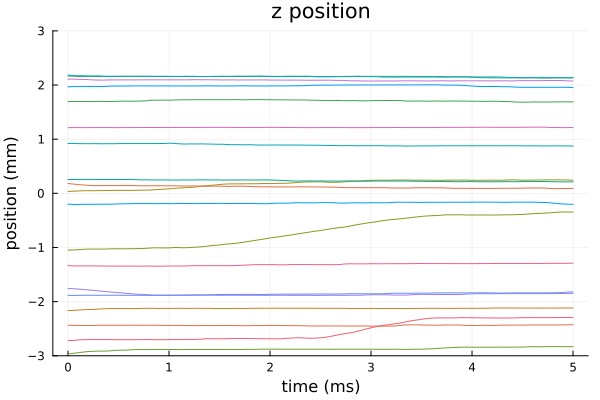

In [ ]:
plot_all_trajectories(results, "z")
plot!(ylim=[-3,3])


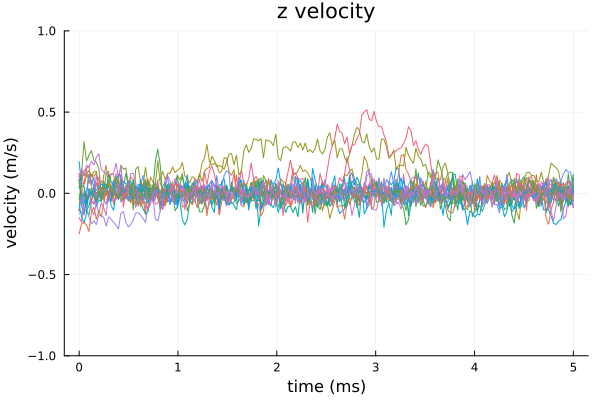

In [ ]:
plot_all_velocities(results,"z")
plot!(ylim=[-1,1])

In [1039]:
results10 = results;

In [537]:
results = bootstrap_iteration(results1, n_values=20);

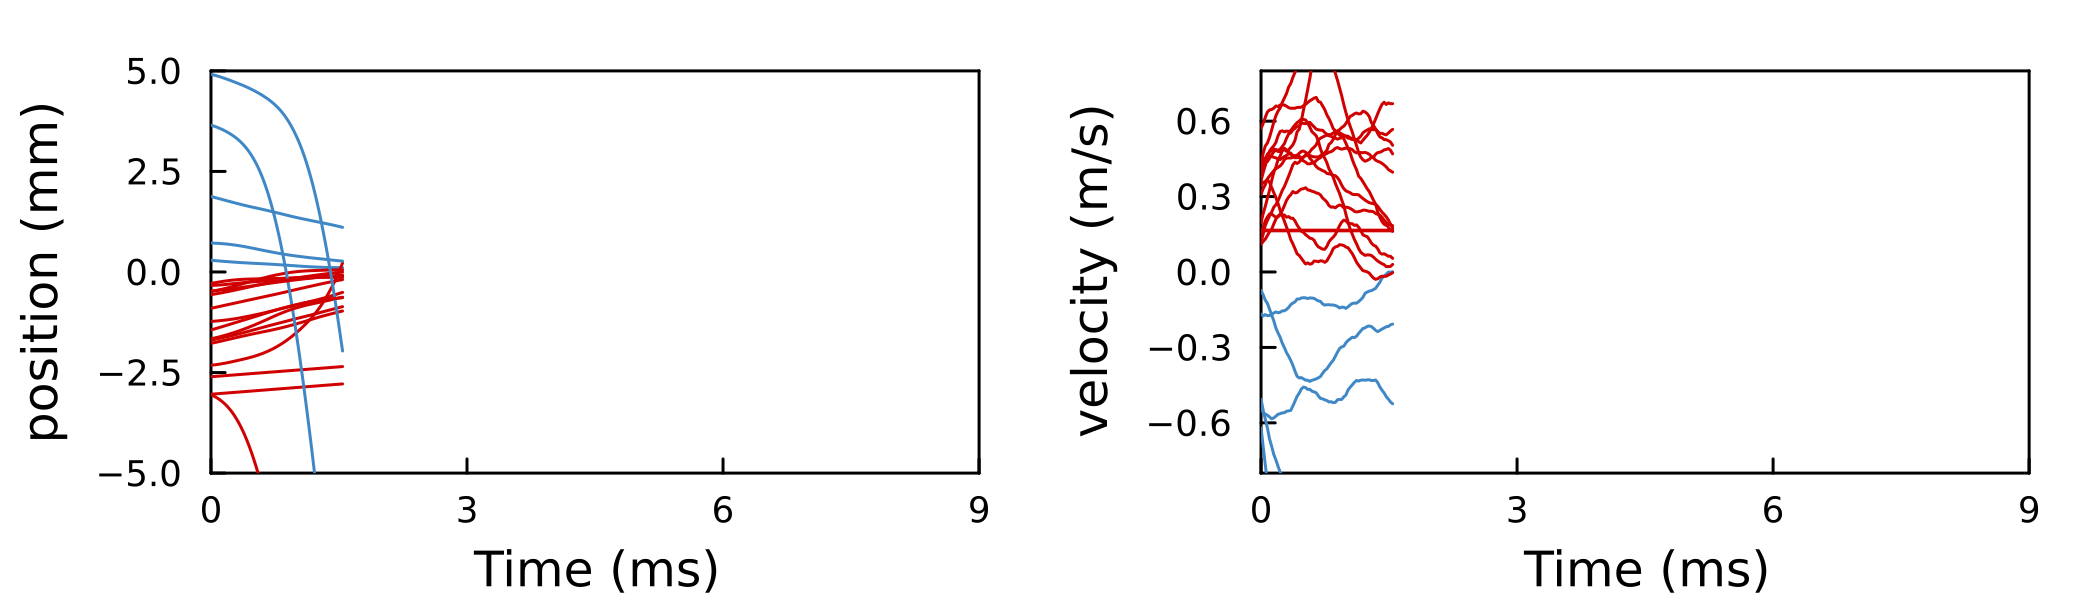

In [1019]:
# results = bootstrap_iteration(results10, n_values=10)
lw = 1;
a = 1
cutoff= 0.01
c1 = "#3F88C5"
c2 = "#D00000"
avg = 20
c_curr = c1

plot1 = plot(legend=nothing,ylim=[-5,5],ylabel="position (mm)")
for i in survived_t(results,2)
    if results.z_trajectories[i][1] > cutoff
        c_curr = c1
    elseif results.z_trajectories[i][1] < -cutoff
        c_curr = c2
    else
        c_curr = c1
    end
    x, y = running_avg(results.times[i],results.z_trajectories[i], avg)
    plot!(x, y, color=c_curr, linewidth=lw, alpha = a)
end

plot2 = plot(legend=nothing,ylim=[-0.8,0.8], ylabel="velocity (m/s)")
for i in survived_t(results,2)
    if results.z_trajectories[i][1] > cutoff
        c_curr = c1
    elseif results.z_trajectories[i][1] < -cutoff
        c_curr = c2
    else
        c_curr = c1
    end
    x, y = running_avg(results.times[i],results.z_velocities[i], avg)
    plot!(x, y, color=c_curr, linewidth=lw, alpha = a)
end

plot(plot1, plot2, layout = (1,2), dpi=300, grid=false, framestyle=:box, xlabel="Time (ms)", xlim=[0,9],size=[700,200],margin = 4Plots.mm)


In [694]:
function running_avg(x, y, n)
    x1 = x[1:length(x) - n + 1]
    y1 = zeros(length(y) - n + 1)

    for i in 1:length(y1)
        y1[i] = sum(y[i:i+n-1])/n
    end
    return x1, y1
end

running_avg (generic function with 1 method)

In [957]:
savefig("C:\\Users\\halla\\OneDrive\\Desktop\\trajectories_20.png");

In [17]:
# TODO: capture velocity and max acceleration vs detuning & intensity, for CaOH and for toy

In [8]:
function find_capture_velocity(params, results)
    trapped = get_trapped_indicies(params, results)
    v_capture = 0.0
    for i in trapped
        if results.x_velocities[i][1] > v_capture && results.x_velocities[i][end] < 2.0 && results.y_velocities[i][end] < 2.0
            v_capture = results.x_velocities[i][1]
        end
    end
    return v_capture * sqrt(2)
end

find_capture_velocity (generic function with 1 method)

In [278]:
# Δs = LinRange(20.0, 400, 10)
# ss = LinRange(5.0, 1000, 10)
# capture_velocities = zeros((length(Δs), length(ss)))
# counter = 0

# for i in 1:length(Δs)
#     Δ = Δs[i]
#     for j in 1:length(ss)
#         # if counter != 47
#         #     counter += 1
#         #     continue
#         # end
#         counter += 1
#         s = ss[j]
#         @printf("Δ = %.1f MHz, s = %.1f \n", Δ, s)
#         # break

#         Δ1 = Δ * 1e6 
#         Δ2 = Δ1 + 1e6
#         s1 = s
#         s2 = s

#         blue_MOT_params.Δ1 = Δ1
#         blue_MOT_params.Δ2 = Δ2
#         blue_MOT_params.s1 = s1
#         blue_MOT_params.s2 = s2

#         test_i = log_test_info_with_molecule_package(saving_dir, counter, blue_MOT_params, package)

#         blue_MOT_params.n_values = 40

#         sequence = [blue_MOT_params]
#         durations = [3e-3]
#         generate_sequence!(sequence, durations);
#         velocities = collect(LinRange(1,50,blue_MOT_params.n_values))
#         results = simulate_particles_constant_diffusion_given_init(package, package_A, sequence, velocities);

#         save_results(saving_dir, test_i, results)
#         capture_velocities[i,j] = find_capture_velocity(blue_MOT_params, results)
#         @printf("Capture velocity = %.1f m/s \n", capture_velocities[i,j])
        
#     end
# end


In [23]:
# blue_MOT_params =  load_test_params(saving_dir, 820)
# test_i = log_test_info_with_molecule_package(saving_dir, 82, blue_MOT_params, package)
# println(test_i)
# blue_MOT_params.n_values = 40

# sequence = [blue_MOT_params]
# durations = [3e-3]
# generate_sequence!(sequence, durations);
# velocities = collect(LinRange(1,40,blue_MOT_params.n_values))
# results = simulate_particles_constant_diffusion_given_init(package, package_A, sequence, velocities);

# save_results(saving_dir, test_i, results)

In [42]:
Δs = LinRange(20.0, 400, 10)
ss = LinRange(5.0, 1000, 10)
capture_velocities = zeros((length(Δs), length(ss)))
counter = 1

for i in 1:length(Δs)
    Δ = Δs[i]
    for j in 1:length(ss)
        results = load_results(saving_dir, counter )
        capture_velocities[i,j] = find_capture_velocity(blue_MOT_params, results)
        counter += 1
    end
end


In [25]:
# best_results = load_results(saving_dir, 1)
# i_best = 1
# for i in 1:100
#     results = load_results(saving_dir, i)
#     if find_capture_velocity(blue_MOT_params, results) > find_capture_velocity(blue_MOT_params, best_results)
#         best_results = results
#         i_best = i
#     end
# end

In [ ]:
# blue_MOT_params =  load_test_params(saving_dir, i_best)
# test_i = log_test_info_with_molecule_package(saving_dir, 101, blue_MOT_params, package)

# blue_MOT_params.n_values = 40

# sequence = [blue_MOT_params]
# durations = [20e-3]
# generate_sequence!(sequence, durations);
# velocities = collect(LinRange(1,40,blue_MOT_params.n_values))
# results = simulate_particles_constant_diffusion_given_init(package, package_A, sequence, velocities);

# save_results(saving_dir, test_i, results)

In [46]:
results = load_results(saving_dir, 40);

In [743]:
results1 = results;
# results = results1;


In [275]:
results = bootstrap_iteration(results1; n_values = 40);

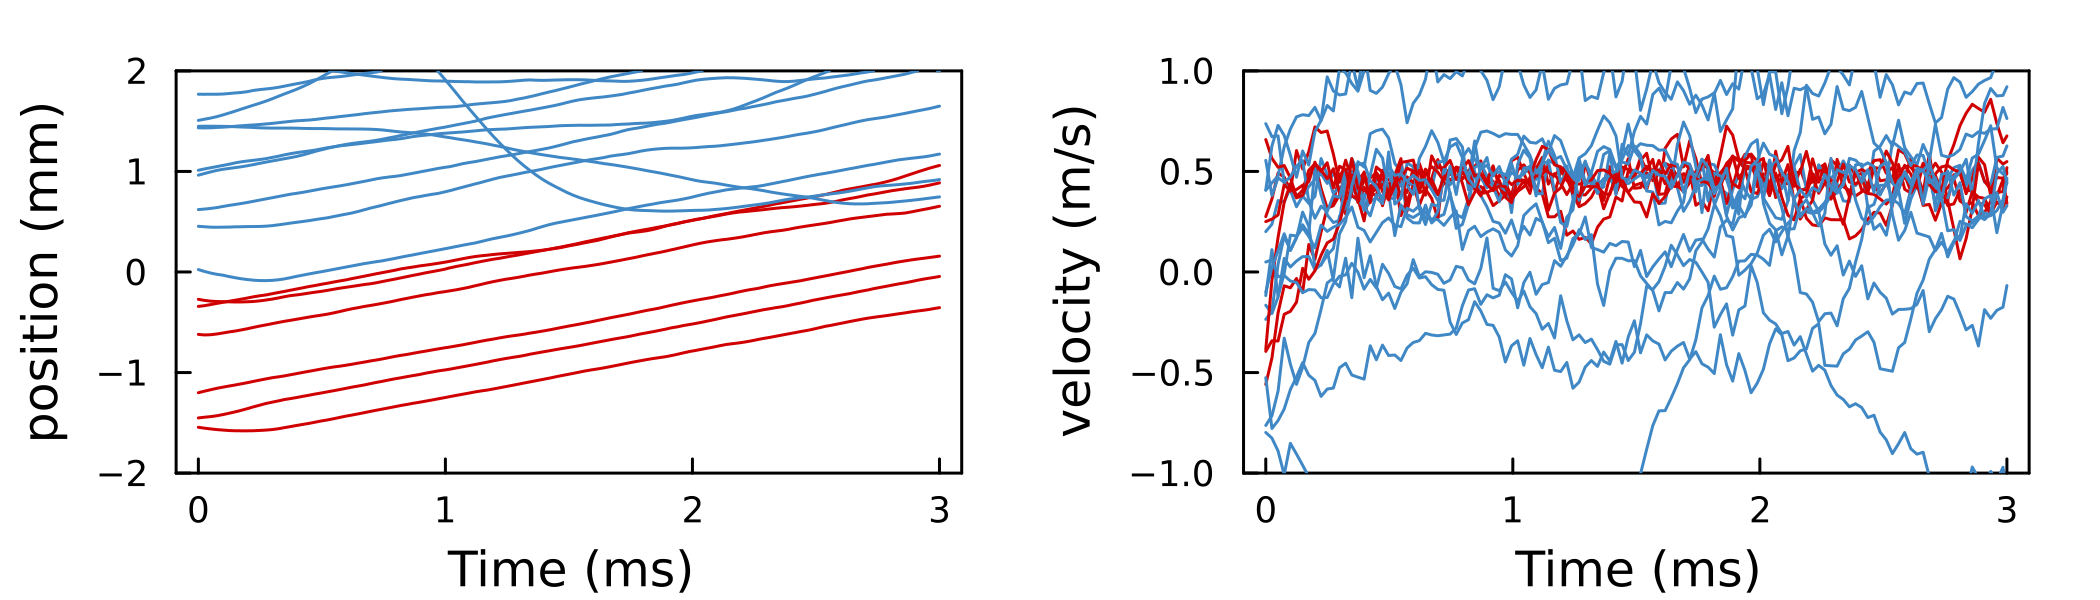

In [294]:
# results = bootstrap_iteration(results1; n_values=30);
lw = 1;
a = 1
cutoff= 0.01
c1 = "#3F88C5"
c2 = "#D00000"

plot1 = plot(legend=nothing,ylim=[-2,2],ylabel="position (mm)")
for i in survived_t(results,3)
    if results.z_trajectories[i][1] > cutoff
        plot!(results.times[i], results.z_trajectories[i], color=c1, linewidth=lw, alpha = a)
    elseif results.z_trajectories[i][1] < -cutoff
        plot!(results.times[i], results.z_trajectories[i], color=c2, linewidth=lw, alpha= a)
    else
        plot!(results.times[i], results.z_trajectories[i], color=:orange, linewidth=lw, alpha = a)
    end
end

plot2 = plot(legend=nothing,ylim=[-1,1], ylabel="velocity (m/s)")
for i in survived_t(results,3)
    if results.z_trajectories[i][1] > cutoff
        plot!(results.times[i], results.z_velocities[i], color=c1, linewidth=lw, alpha = a)
    elseif results.z_trajectories[i][1] < -cutoff
        plot!(results.times[i], results.z_velocities[i], color=c2, linewidth=lw, alpha = a)
    else 
        plot!(results.times[i], results.z_velocities[i], color=:orange, linewidth=lw, alpha = a)
    end
end

plot(plot1, plot2, layout = (1,2), dpi=300, grid=false, framestyle=:box, xlabel="Time (ms)", size=[700,200],margin = 4Plots.mm)


In [825]:
savefig(saving_dir * "\\trajectories_colored.png")

"C:\\Users\\halla\\OneDrive\\Desktop\\CaOH_high_capture_MOT_sim\\trajectories_colored.png"

6.4e6

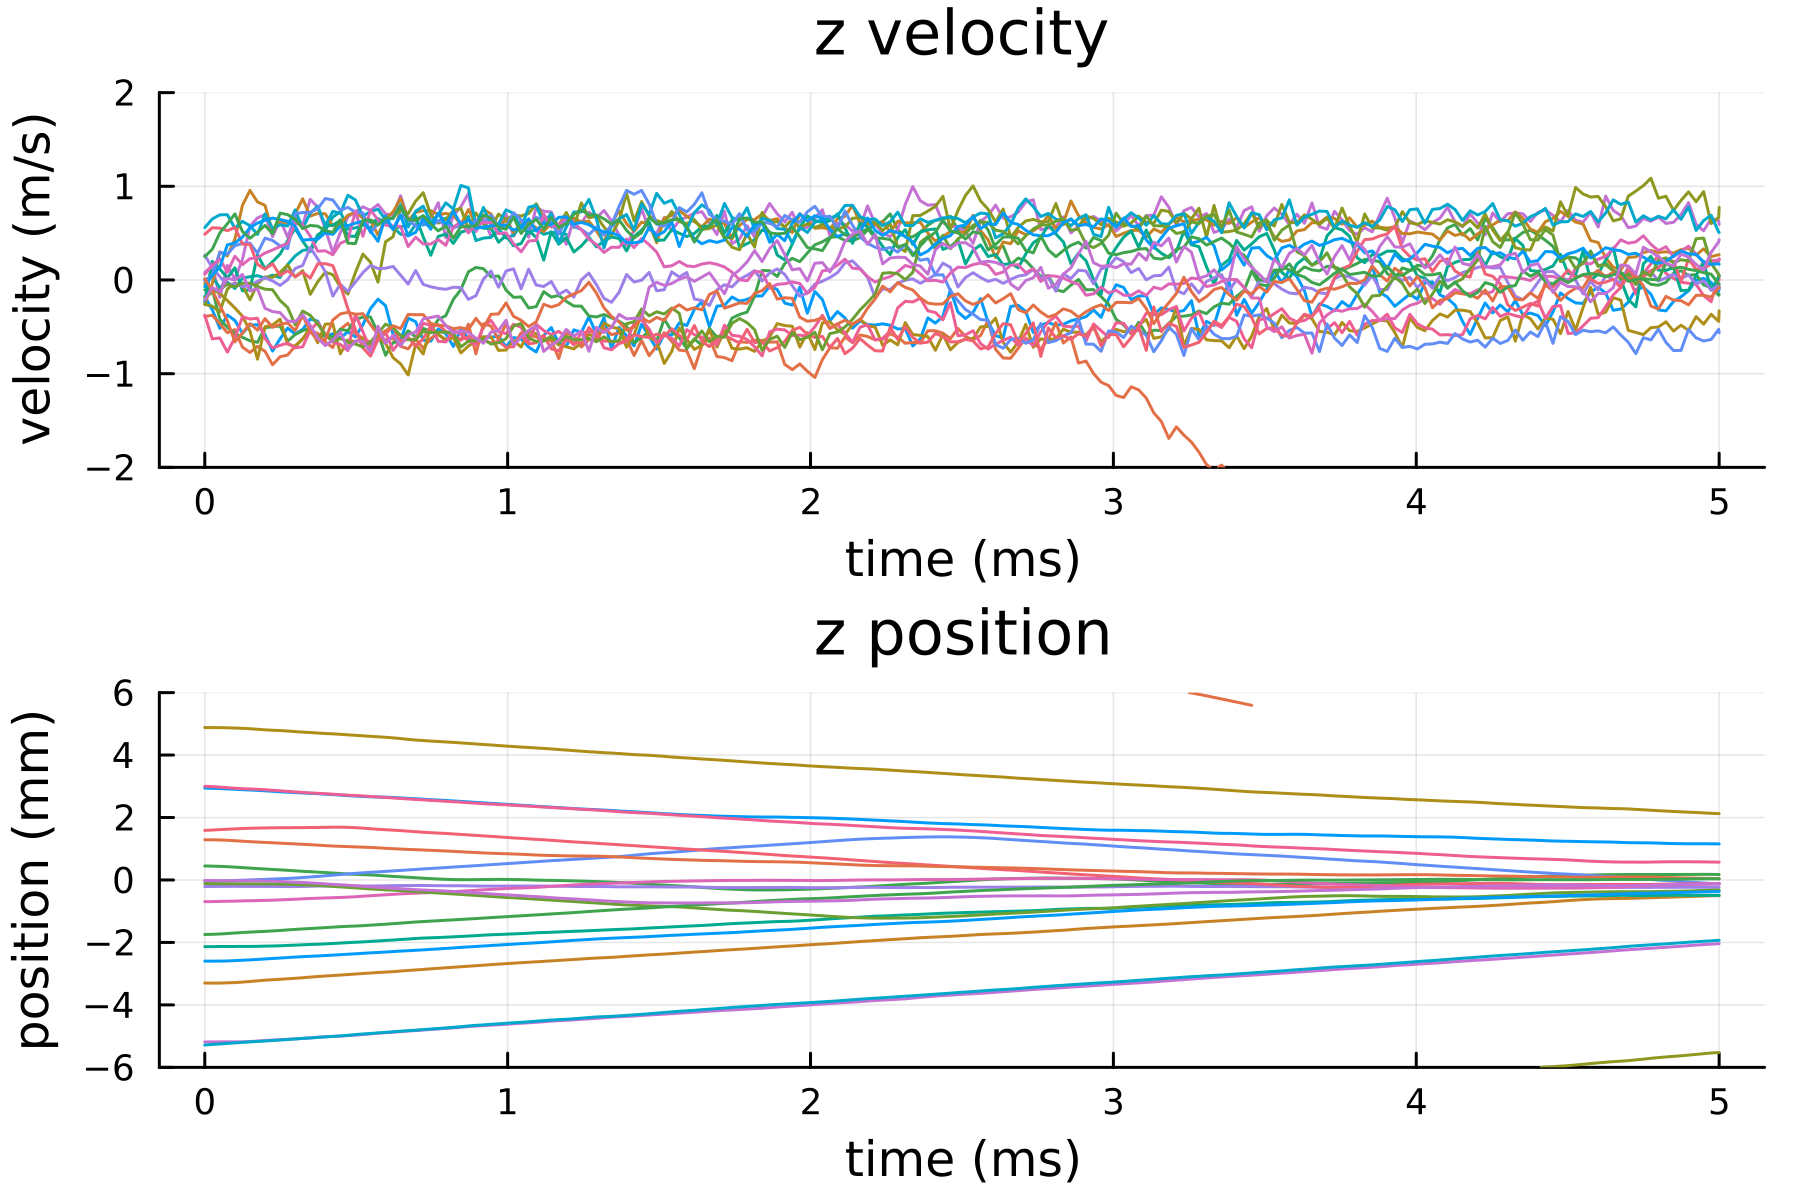

In [43]:
# results = bootstrap_iteration(results1; n_values = 20);
plot_all_velocities(results, "z")
plot1 = plot!(ylim=[-2,2])
plot_all_trajectories(results, "z")
plot2 = plot!(ylim=[-6,6])
plot(plot1, plot2, layout = (2,1), dpi=300)
# savefig(saving_dir * "\\trajectories.png")

In [534]:
plot_all_velocities(blue_MOT_params, best_results)
plot!()

LoadError: UndefVarError: `best_results` not defined

In [43]:
heatmap(ss, Δs, capture_velocities, xlabel="s", ylabel="Δ (MHz)", title="Capture velocity (m/s)", dpi=300)
savefig(saving_dir * "\\capture velocity toy.png")

"C:\\Users\\halla\\OneDrive\\Desktop\\toy_high_capture_MOT_sim\\higher\\capture velocity toy.png"

In [25]:
results = load_results(saving_dir, 1);
find_capture_velocity(blue_MOT_params, results)

0.0

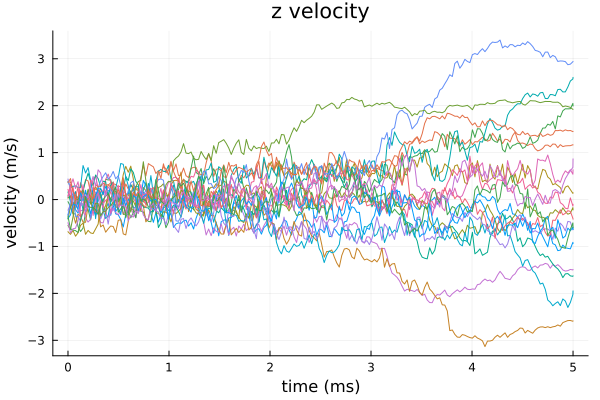

In [35]:
plot_all_velocities(results, "z")
plot!()

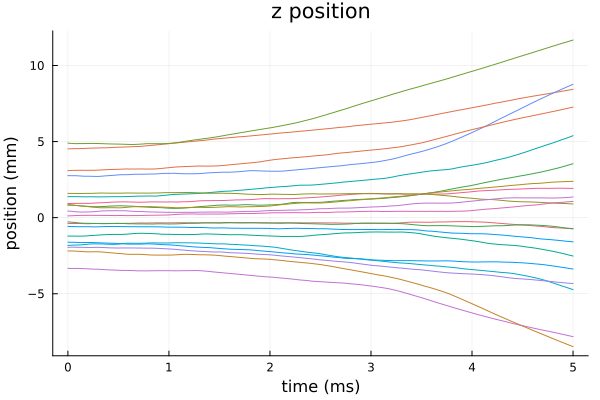

In [36]:
plot_all_trajectories(results, "z")
plot!()

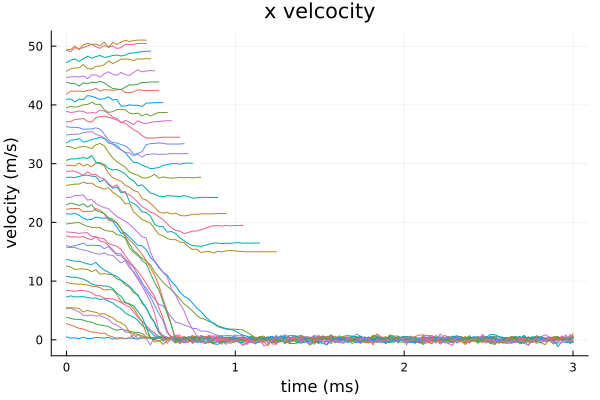

In [325]:
i_test = 70
params1 = load_test_params(saving_dir, i_test);
results = load_results(saving_dir, i_test);
plot_all_velocities(results, "x")
plot!()

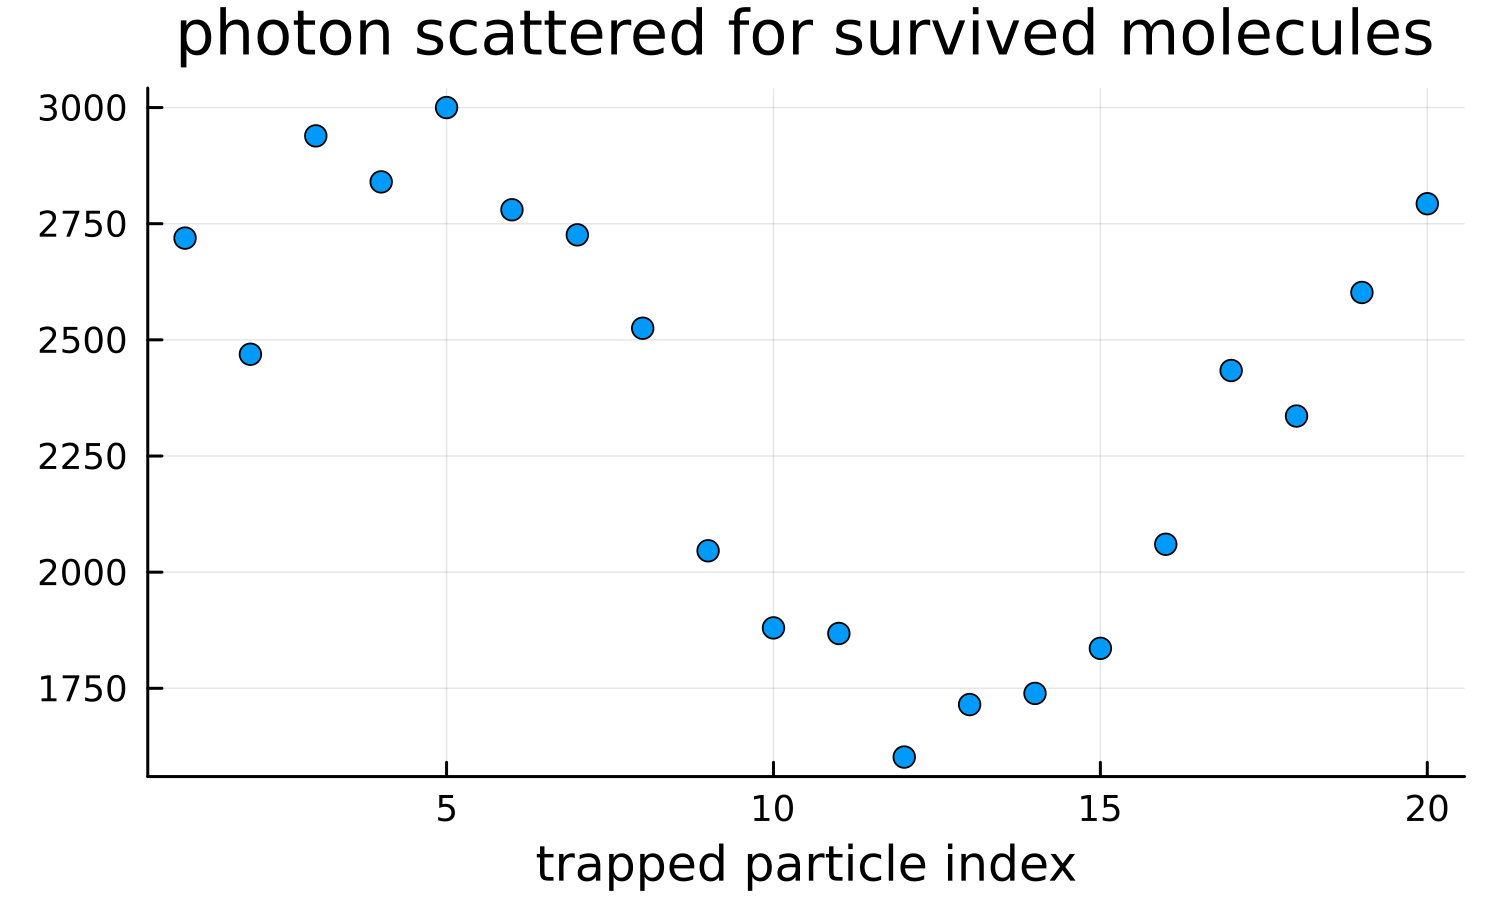

In [328]:
plot_photons_scattered(results)
plot!()

In [81]:
0.5e6/(Γ/2π)

0.078125

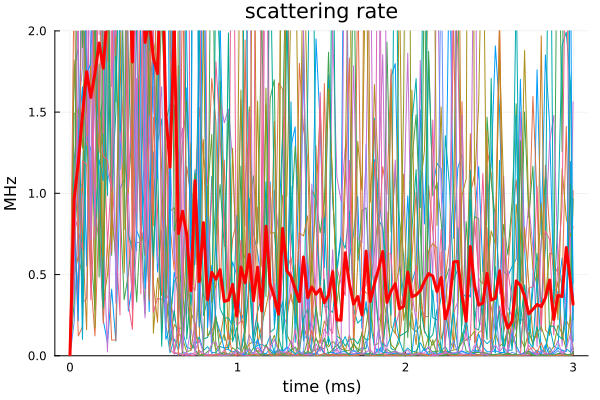

In [326]:
plot_survival_scattering_rate(params1, results)
plot!(ylim=[0,2])

In [5]:

using
    DifferentialEquations,
    LinearAlgebra
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using Parameters

import ProgressMeter: Progress, next!

import OpticalBlochEquations.simulate_particles_constant_diffusion

function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx 
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time 
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = +(scalar * p.sim_params.B_gradient + p.sim_params.B_grad_start) * 1e2 / k/2 
    gradient_y = +(scalar * p.sim_params.B_gradient+ p.sim_params.B_grad_start) * 1e2 / k/2 
    gradient_z = -(scalar * p.sim_params.B_gradient+ p.sim_params.B_grad_start) * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    # Update the Hamiltonian for the molecule-ODT interaction
    H_ODT = p.extra_data.H_ODT_static
    
    ODT_size = p.sim_params.ODT_size .* p.k
    update_ODT_center!(p, t)
    ODT_x = p.extra_data.ODT_position[1] * p.k
    ODT_z = p.extra_data.ODT_position[2] * p.k
    
    scalar_ODT = exp(-2(r[1]-ODT_x)^2/ODT_size[1]^2) * exp(-2r[2]^2/ODT_size[2]^2) * exp(-2(r[3]-ODT_z)^2/ODT_size[3]^2)
    
    @turbo for i in eachindex(H)
        H.re[i] += H_ODT.re[i] * scalar_ODT
        H.im[i] += H_ODT.im[i] * scalar_ODT
    end
    
    # return SVector{3,ComplexF64}(0,0,0)
    return SVector{3,ComplexF64}((-4(r[1]-ODT_x) / ODT_size[1]^2) * scalar_ODT, (-4r[2] / ODT_size[2]^2) * scalar_ODT, (-4(r[3]-ODT_z) / ODT_size[3]^2) * scalar_ODT)
    
end
;

function make_problem_with_param_constant_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k 

    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick

    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1],m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2],m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3],m)

  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
   photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        B_grad_start = param.B_grad_start,
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,
        
        s_total = s1 + s2 + s3 + s4,
        diffusion_constant = param.diffusion_constant
        )

    t_span = (t_start, t_end) ./ (1/Γ);
    
    ω1 = 2π * (states[end].E - states[1].E) + Δ1 * 2π
    ω2 = 2π * (states[end].E - states[1].E)  + Δ2 * 2π
    ω3 = 2π * (states[end].E - states[4].E)  + Δ3 * 2π
    ω4 = 2π * (states[end].E - states[4].E)  + Δ4 * 2π

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1.0#1/2-rand()
    sy_rand = 1.0#1/2-rand()
    sz_rand = 1.0#1/2-rand()

    # TODO: put retros back
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z , s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss) , s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
        
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end
               
    return prob
end

function simulate_particles_constant_diffusion(package, package_A, sequence_of_params)
    
    n_values = sequence_of_params[1].n_values
    n_threads=Threads.nthreads()
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    prog_bar = Progress(n_values)

    n_states = length(package.states)
    n_excited = package.n_excited

    x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    x_velocities = Array{Vector{Float64}}(fill([],n_values))
    y_velocities = Array{Vector{Float64}}(fill([],n_values))
    z_velocities = Array{Vector{Float64}}(fill([],n_values))
    A_populations = Array{Vector{Float64}}(fill([],n_values))
    times = Array{Vector{Float64}}(fill([],n_values))
    photons_scattered = zeros(n_values)

                            
    results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
                                x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
                                times=times, A_populations=A_populations,
                                n_values=n_values, photons_scattered=photons_scattered, n_states = n_states, n_excited=n_excited,
                                Γ = package.Γ, k=package.k)

    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))

    Threads.@threads for i ∈ 1:n_threads
    
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)

        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1) 
            ψ0 = nothing
            for i_param in 1:length(sequence_of_params)
                randomize = false
                if i_param == 1
                     randomize = true
                end
                params = sequence_of_params[i_param]      
                prob_copy = make_problem_with_param_constant_diffusion(package, package_A, params, randomize_initial_vector = randomize, ψ0=ψ0)
                ψ0 = continue_particle_constant_diffusion!(j, results, prob_copy)    
                if abs(params.t_end - results.times[j][end]*1e-3) > 1e-3
                          break # this particle has already died
                end
            end

            next!(prog_bar)
        end
    end
    
    return results
end
                                
function simulate_particles_constant_diffusion_given_init(package, package_A, sequence_of_params, velocities)
    
    n_values = sequence_of_params[1].n_values
    n_threads=Threads.nthreads()
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    prog_bar = Progress(n_values)

    n_states = length(package.states)
    n_excited = package.n_excited

    x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    x_velocities = Array{Vector{Float64}}(fill([],n_values))
    y_velocities = Array{Vector{Float64}}(fill([],n_values))
    z_velocities = Array{Vector{Float64}}(fill([],n_values))
    A_populations = Array{Vector{Float64}}(fill([],n_values))
    times = Array{Vector{Float64}}(fill([],n_values))
    photons_scattered = zeros(n_values)

                            
    results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
                                x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
                                times=times, A_populations=A_populations,
                                n_values=n_values, photons_scattered=photons_scattered, n_states = n_states, n_excited=n_excited,
                                Γ = package.Γ, k=package.k)

    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))

    Threads.@threads for i ∈ 1:n_threads
    
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)

        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1) 
            ψ0 = nothing
            for i_param in 1:length(sequence_of_params)
                randomize = false
                if i_param == 1
                     randomize = true
                end

                params = deepcopy(sequence_of_params[i_param])    
                params.kick = [velocities[j], velocities[j], 0]
                prob_copy = make_problem_with_param_constant_diffusion(package, package_A, params, randomize_initial_vector = randomize, ψ0=ψ0)
                ψ0 = continue_particle_constant_diffusion!(j, results, prob_copy)    
                if abs(params.t_end - results.times[j][end]*1e-3) > 1e-3
                          break # this particle has already died
                end
            end

            next!(prog_bar)
        end
    end
    
    return results
end                               
                                


import OpticalBlochEquations.SE_collapse_pol_constant_diffusion!
function SE_collapse_pol_constant_diffusion!(integrator)

    p = integrator.p
    n_states = p.n_states
    n_excited = p.n_excited
    n_ground = p.n_ground
    d = p.d
    ψ = integrator.u
    
    
 
    
    # A photon is observed.
    # Measure the polarization of the photon along z.
    p⁺ = 0.0
    p⁰ = 0.0
    p⁻ = 0.0
    
    for i ∈ 1:n_excited
        ψ_pop = norm(ψ[n_ground + i])^2
        for j ∈ 1:n_ground
            p⁺ += ψ_pop * norm(d[j,n_ground+i,1])^2
            p⁰ += ψ_pop * norm(d[j,n_ground+i,2])^2
            p⁻ += ψ_pop * norm(d[j,n_ground+i,3])^2
        end
        # note the polarization p in d[:,:,p] is defined to be m_e - m_g, 
        # whereas the polarization of the emitted photon is m_g - m_e
    end
    
    p_norm = p⁺ + p⁰ + p⁻
    rn = rand() * p_norm
    for i ∈ 1:n_ground
        ψ[i] = 0.0
    end

    
    pol = 0
    if 0 < rn <= p⁺ # photon is measured to have polarization σ⁺
        pol = 1
    elseif p⁺ < rn <= p⁺ + p⁰ # photon is measured to have polarization σ⁰
        pol = 2
    else # photon is measured to have polarization σ⁻
        pol = 3
    end
    
    for i in 1:n_ground
        for j in (n_ground+1):n_states
            ψ[i] += ψ[j] * d[i,j,pol]
        end
    end
    
    # zero excited state amplitudes
    for i ∈ (n_ground + 1):n_states
        ψ[i] = 0.0
    end
    
    ψ_norm = 0.0
    for i ∈ 1:n_states
        ψ_norm += norm(ψ[i])^2
    end
    ψ_norm = sqrt(ψ_norm)
    for i ∈ 1:n_states
        ψ[i] /= ψ_norm
    end
    
    p.n_scatters += 1
    
    # zero excited state populations
    for i ∈ (n_states+1):(n_states+n_excited)
        integrator.u[i] = 0.0
    end

    
    dp = sample_direction(1)
    dv = dp ./ p.mass
    integrator.u[n_states + n_excited + 4] += dv[1]
    integrator.u[n_states + n_excited + 5] += dv[2]
    integrator.u[n_states + n_excited + 6] += dv[3]
    
    time_before_decay = integrator.t - p.last_decay_time
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 4] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 5] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 6] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    p.last_decay_time = integrator.t
    
    p.time_to_decay = rand(p.decay_dist)
    return nothing
end
                                                                                        
                                                                                        
import OpticalBlochEquations.make_problem_with_param_diffusion
function make_problem_with_param_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k         
                
    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick
    
    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1], m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2], m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3], m)
  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
    
    photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,

        dt = param.dt
        )

    t_span = (t_start, t_end) ./ (1/Γ)
    
    ω1 = 2π * (states[end].E - states[1].E) + Δ1 * 2π
    ω2 = 2π * (states[end].E - states[1].E)  + Δ2 * 2π
    ω3 = 2π * (states[end].E - states[6].E)  + Δ3 * 2π
    ω4 = 2π * (states[end].E - states[6].E)  + Δ4 * 2π

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1.0#1/2-rand()
    sy_rand = 1.0#1/2-rand()
    sz_rand = 1.0#1/2-rand()
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
                            
    p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_diffusion!, p.ψ, t_span, p)
    
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end

     reset_operator_diagonal!(prob.p.P_x, prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)
     reset_operator_diagonal!(prob.p.P_y, prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)
     reset_operator_diagonal!(prob.p.P_z, prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)
     
     reset_operator_diagonal!(prob.p.Px_sq, (prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)^2)
     reset_operator_diagonal!(prob.p.Py_sq, (prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)^2)
     reset_operator_diagonal!(prob.p.Pz_sq, (prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)^2)
     
     reset_operator_diagonal!(prob.p.U_t, 1)
     reset_operator_diagonal!(prob.p.U_t_dagger, 1)
     
     for i ∈ eachindex(prob.p.ψ_prev)
         prob.p.ψ_prev[i] = prob.p.ψ[i]
     end
    
    return prob
end    

import OpticalBlochEquations.condition
function condition(u,t,integrator)
    p = integrator.p
    integrated_excited_pop = 0.0
    for i ∈ 1:p.n_excited
        integrated_excited_pop += real(u[p.n_states+i])
    end
    
    _condition = integrated_excited_pop - p.time_to_decay
    
    r = 0.0
    for i ∈ 1:3
        r += norm(u[p.n_states + p.n_excited + i])^2
    end
    r = sqrt(r)
    if r >= 20e-3*k # terminate if the particle is more than 3 mm from the centre
       terminate!(integrator) 
    elseif integrator.p.n_scatters > integrator.p.sim_params.photon_budget # also terminate if too many photons have been scattered
        terminate!(integrator)
    end
    return _condition
end


function gaussian_intensity_along_axes(r, axes, centers)
    """1/e^2 width = 5mm Gaussian beam """
    d2 = (r[axes[1]] - centers[1])^2 + (r[axes[2]] - centers[2])^2   
    return exp(-2*d2/(10e-3/(1/k))^2)
    end

function gaussian_intensity_along_axes(r, axes, centers, k)
    """1/e^2 width = 5mm Gaussian beam """
    d2 = (r[axes[1]] - centers[1])^2 + (r[axes[2]] - centers[2])^2   
    return exp(-2*d2/(10e-3/(1/k))^2)
    end

gaussian_intensity_along_axes (generic function with 2 methods)